# Lesson: Distributions

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.ticker as mtick


az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

## Breaking apart our A/B testing model

```python
with pm.Model() as model_a:
    # Parameter = prior solution space
    conversion_rate = pm.Beta("conversion_rate_a", alpha=2, beta=10)

    # Evaluator: likelihood function
    how_likely = pm.Bernoulli("how_likely", p=conversion_rate, observed=a_observations)
```

You've now seen the A/B testing model a couple of times and even used it yourself in the last lesson. In this lesson we're going to break it apart into its smallest pieces. Why are we doing this? In the first lesson we talked about how Bayesian Models are like Lego. We handed you a complete Lego in the first three lessons with A/B test model. By showing you how its built you'll be better prepared to then use that knowledge to build more complex models, such as the ones in later lessons.

## Distributions are the smallest building blocks

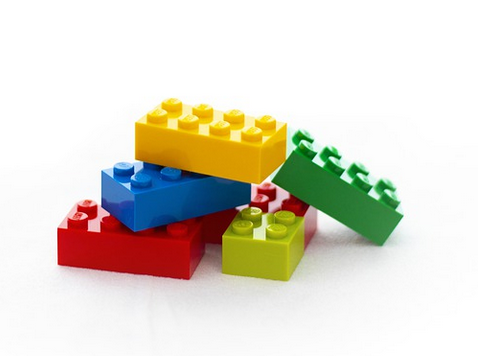

That smallest piece is a distribution.  

We'll learn what they are in this lesson, as well as some of their useful properties such as Probability Mass and Distribution functions, and computation sampling. These ideas are core to Bayesian modeling and understanding them give you a great intuition as to what's happening under the hood of PyMC.

Let's jump in!

## Distributions and Uncertainty

* How distributions formalize uncertainty
* Why we'll focus on computational specification
* How distributions are central to Bayes Theorem

## Distribution Parameters
* What distribution parameters are
* How they define the shape of a distribution
* That there are differing naming conventions

## PMF and PDF
* How to compare relative beliefs using Probability Density and Probability Mass functions
* How to calculate PDF and PMF
* Why this is important in a Bayesian context

## Two Types of Samples
* The two types of samples in Bayesian inference 
  * Observed samples of your data
  * Samples from computational distributions
* How both connect to Bayesian inference

## Why distributions

Why distributions are a fundamental tool in summarizing observations, parameters, and uncertainty

In [3]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)

## Revisiting our A/B test

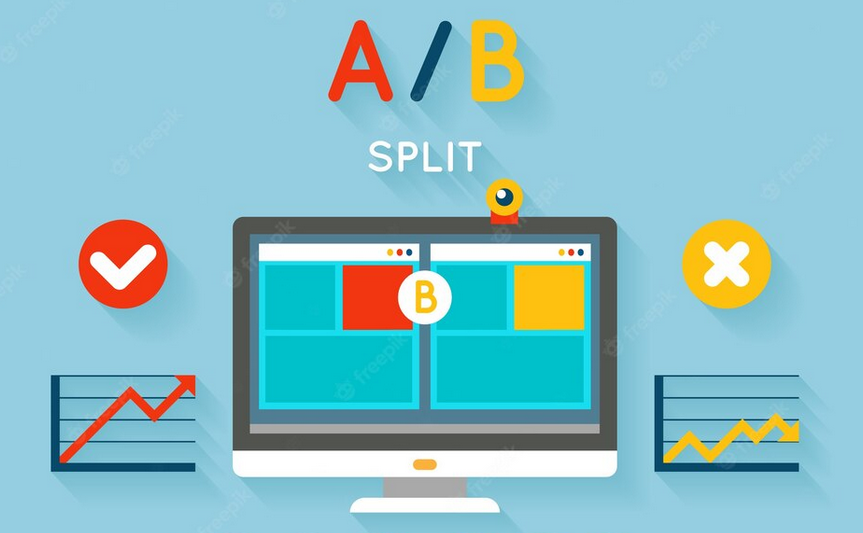

<a href="https://www.freepik.com/vectors/people">People vector created by macrovector - www.freepik.com</a>

Let's revisit our A/B test. Remember why we're doing this. We want estimate if Website A or Website B has a better conversion rate. Regardless of what estimation technique we use we'll need data.

In [4]:
# If reading this outside of the video I'm saving the data locally as we don't cover 
# sampling until a later section!
a_observations = pd.read_csv("ab-test-data.csv", index_col=0)

## Load our historical data

In [5]:
a_observations.shape

(100, 1)

For now let's just focus on website B. We want to estimate what the probability is someone will convert on website B. We can our observed data to form an estimate.

# Calculating our conversion rate the naive way

In [6]:
numerator = a_observations.values.sum()
denominator = a_observations.shape[0]
numerator, denominator,  f"{numerator/denominator*100}% conversion"

(8, 100, '8.0% conversion')

The easiest way to do it is to take the average which gets us an answer of 10%.

But how sure are we exactly .1 or 10% is the true conversion rate,
why couldn't it 9.9% or 10.1%, or even 5% or 99%?

## A single number can't convey how sure we are

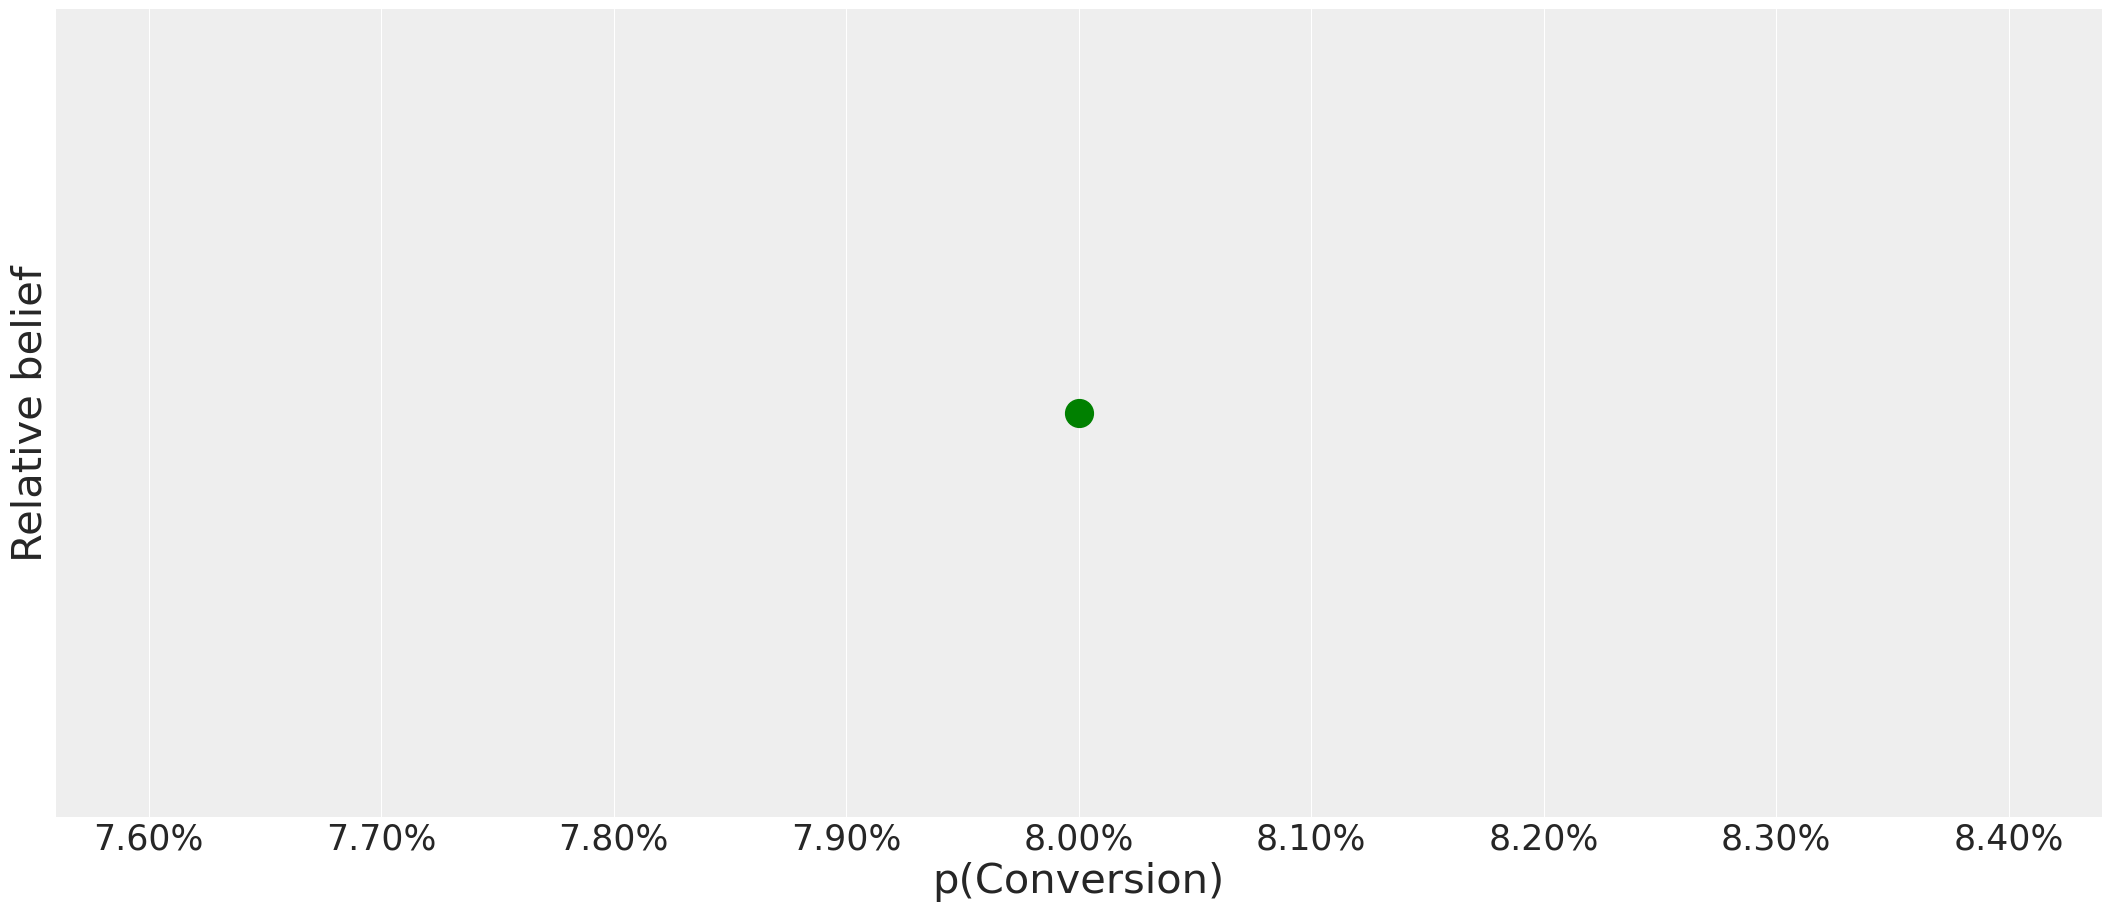

In [16]:
fig, ax = plt.subplots(figsize=(21,9))

ax.plot(a_observations.mean(), 1 ,'o', c='g', markersize=20)

ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,
                                   decimals=None))
ax.set_yticks([]);


If we just take the mean all we get is this dot, which tells us nothing about the plausibility of any other possible conversion rate.

Every value from 0 to 1 could be plausible but we also intuitively know some values are more plausible than others

## Describing plausibility with distributions

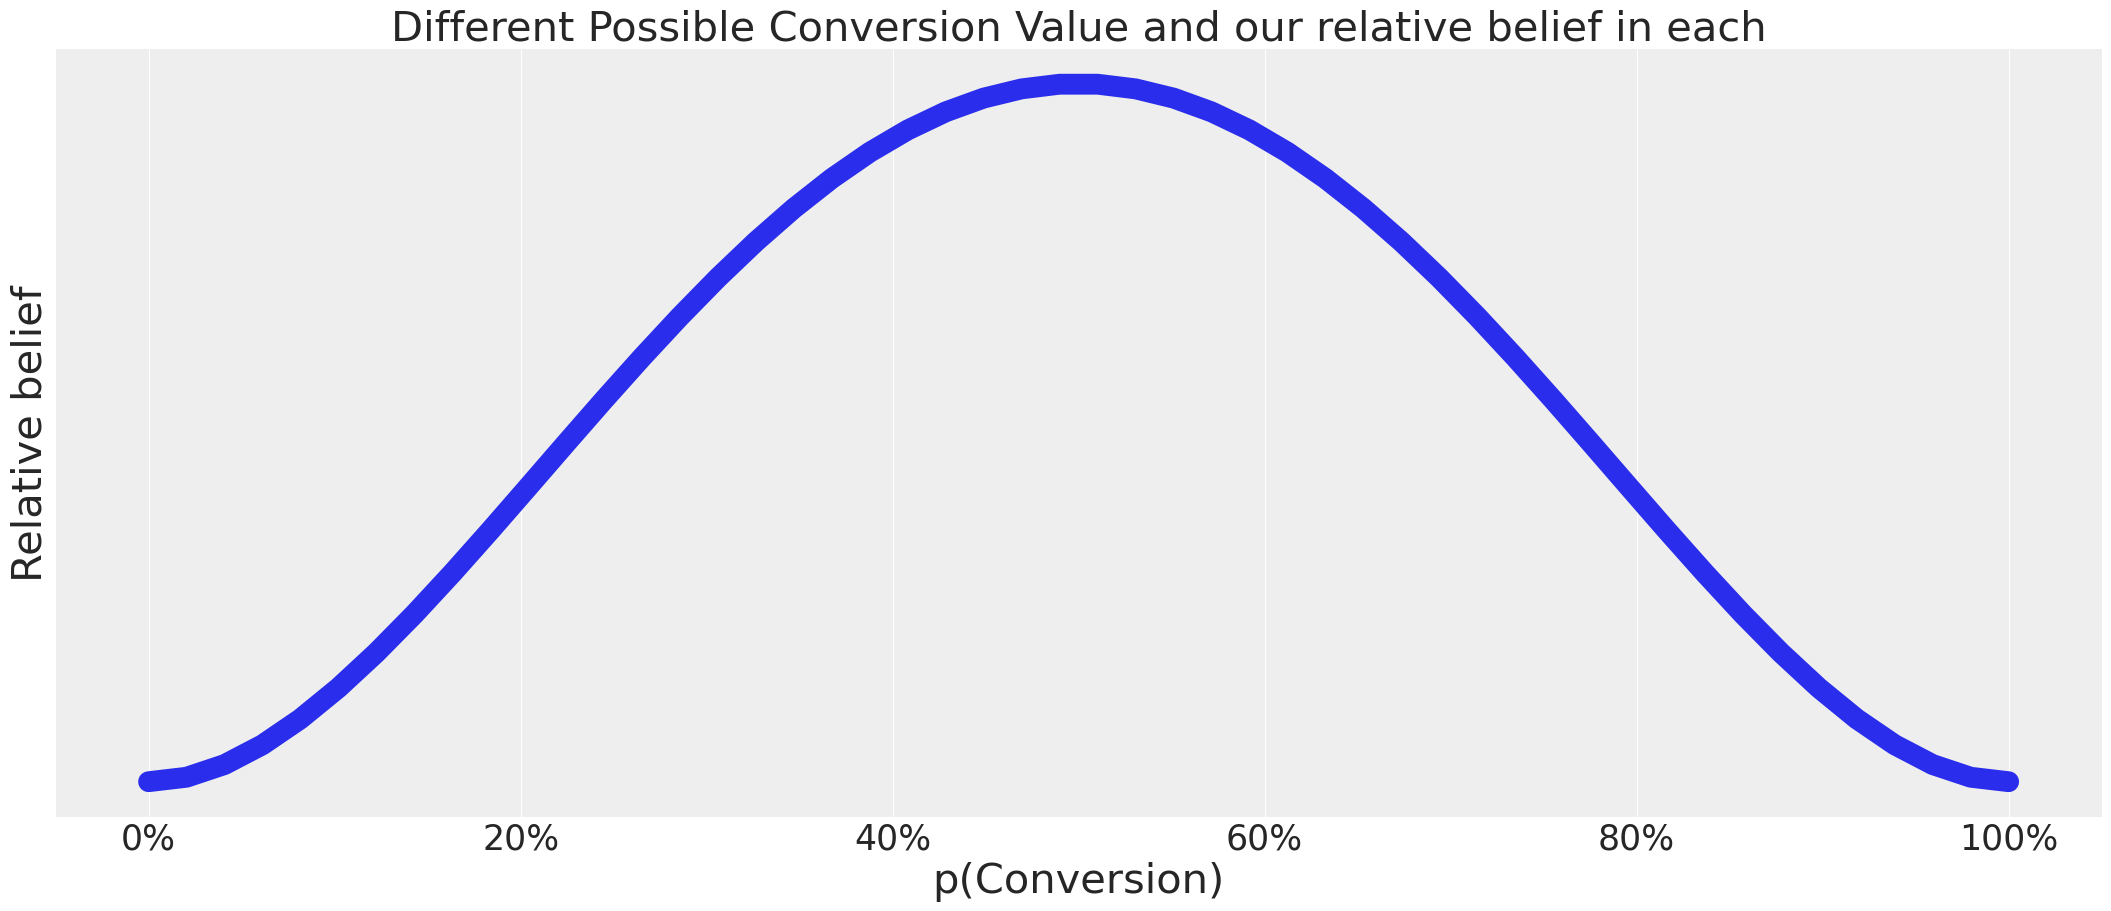

In [10]:

beta_dist = stats.beta(3, 3)
x = np.linspace(0, 1)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)


# x = [.1, .2, .5, .8]

# for i in x:
#     ax.plot(i,y.mean() ,'o', c='g', markersize=20)


ax.set_yticks([])
ax.set_title("Different Possible Conversion Value and our relative belief in each", fontsize=30)

# ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,
                                   decimals=None))
ax.set_yticks([]);


The key idea in Bayesian statistics:


Quantifying uncertainty using probability distributions. The distribution conveys our belief in *every possible conversion value*. This is the key idea in Bayesian statistics.

The x axis is every possible value of the *probability of conversion* and the blue line is our relative belief in each value.

## Another possible belief distribution for conversion

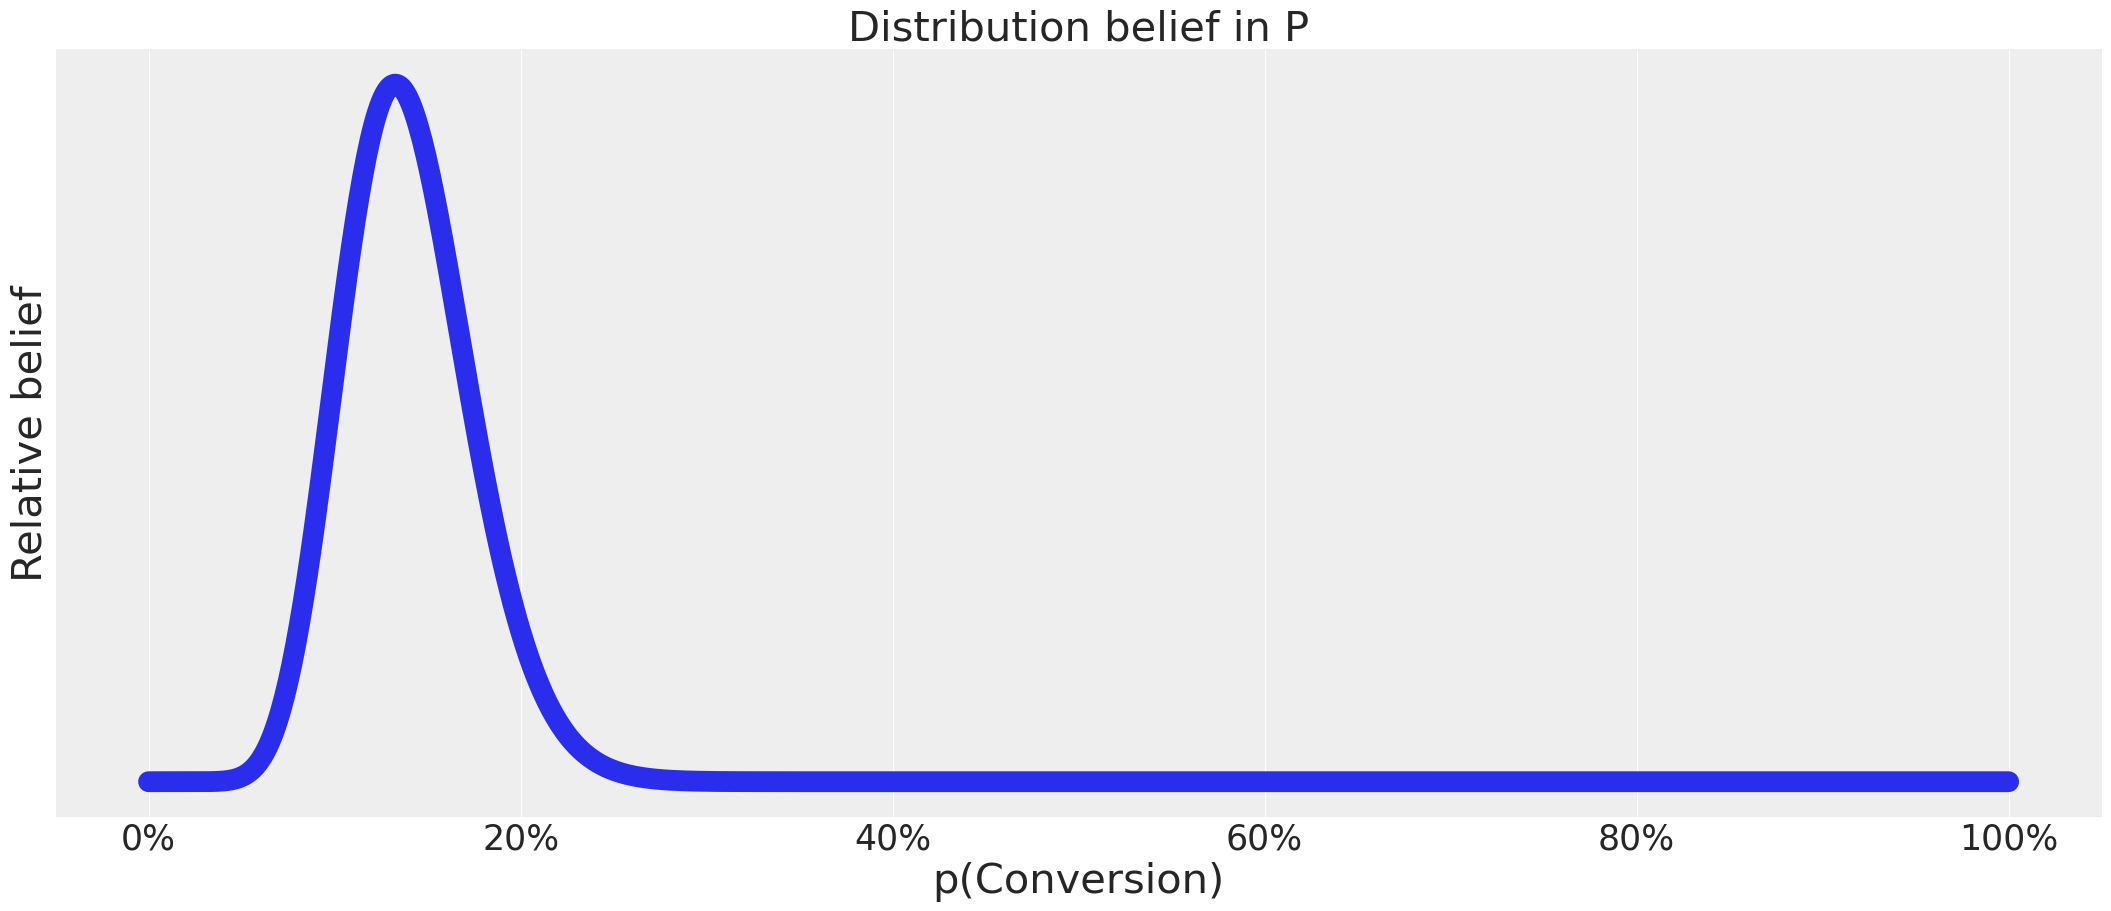

In [23]:
beta_dist = stats.beta(14, 86)
x = np.linspace(0, 1, 1000)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)

ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,
                                   decimals=None))
ax.set_yticks([]);


The shape and domain of the distribution conveys our belief. Now were expressing a belief where that the true conversion rate is concentrated concentrated around 10%

## Distributions are not just for probabilities but observations too

In [13]:
heights_of_random_people = [190, 191, 195, 192, 193, 200, 205, 210]

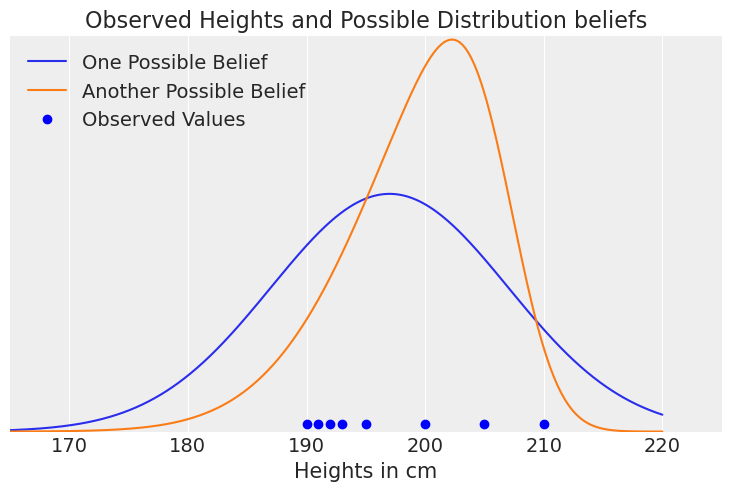

In [14]:
# Hide this code block
fig, ax = plt.subplots()
y = 0


ax.set_title("Observed Heights and Possible Distributional Beliefs")

x = np.linspace(160, 220, 1000)
y = stats.norm(np.mean(heights), 10).pdf(x)
ax.plot(x,y, label="One Possible Belief")

y = stats.skewnorm(loc=np.mean(heights)+10, scale=10, a=-3).pdf(x)
ax.plot(x,y, label="Another Possible Belief")


for i in heights:
    ax.plot(i,np.max(y)*.02 ,'o', c='b', label="Observed Values" if i == 190 else "")

ax.set_ylim(0, np.max(y)*(1+.01))
ax.set_xlim(165, 225)
plt.legend()

ax.set_xlabel("Heights in cm")
ax.set_yticks([]);



Distributions aren't just limited to our belief in unobserved concepts like p conversion, but also to observed measurements, like the height of people.

Lets say we observe the heights of various people. What could be the heights of the next 100 people you see. It won't just be a mean number, it will be a distribution! 



## Why Bayes is the best



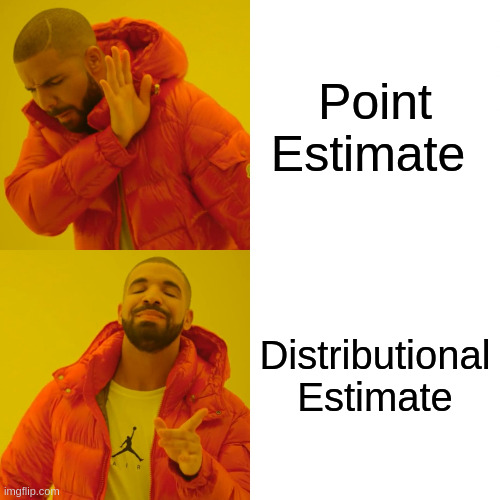

We don't just get *one* value we believe *every* value and can precisely describe by how much.

This distributional belief system is a key differentiator of Bayesian approaches versus most other machine learning methods and also enables some really cool capabilities you're going to see in this lesson and the next.

## Section Recap
* Distributions convey more information than point estimates. In particular
  * The range of our uncertainty
  * The value of that uncertainty
  
* Different shapes of distributions express different beliefs

# What are distributions?
How they are defined and how you can define them

## They're not necessarily Bayesian
<center><img src="img/NotBayes.jpg"/></center>

You may have gotten the idea by now that using distributions means you're Bayesian. Let's clear this up now. While Bayes theorem is built from distributions, it itself is not Bayesian.

## Distributions are math functions

$$ \Large
\text{Relative_Belief} = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\, x^{\alpha-1}(1-x)^{\beta-1} 
$$


Distributions at their purest form are just mathematical functions though they do have *special properties*.
Here's the equation for a Normal Distribution Probability Density Function

This theoretical definition is important for proofs and theory

Distributions at their purest form as just mathematical functions. They take in values and output values.

Now these functions are specifically defined, and their outputs mean something specific but we'll get to that in the next section.

Think of distributions like bricks. A brick isn't a house, but it can be used to build one.

## Distributions as code

In [15]:
# Distribution defined using scipy
norm = stats.norm(0,1)

# Distribution in PyMC defined in a model context
with pm.Model():
    beta = pm.Normal("Normal_dist", 0,1)

Before I scare you too much with math, know in this course distributions will be code, as you've already seen. 

By using available code library we'll be able to automate the algebra and simultaneously take advantage of computation to do some really neat stuff.

Before we get to that though lets talk about how to fully define a distributions

##  How to fully specify a distribution
You need two parts
* The distribution
* The specific parameterization

## A/B Test Conversion Belief
Beta is a good choice because it's bounded from 0 to 1, just like probability.

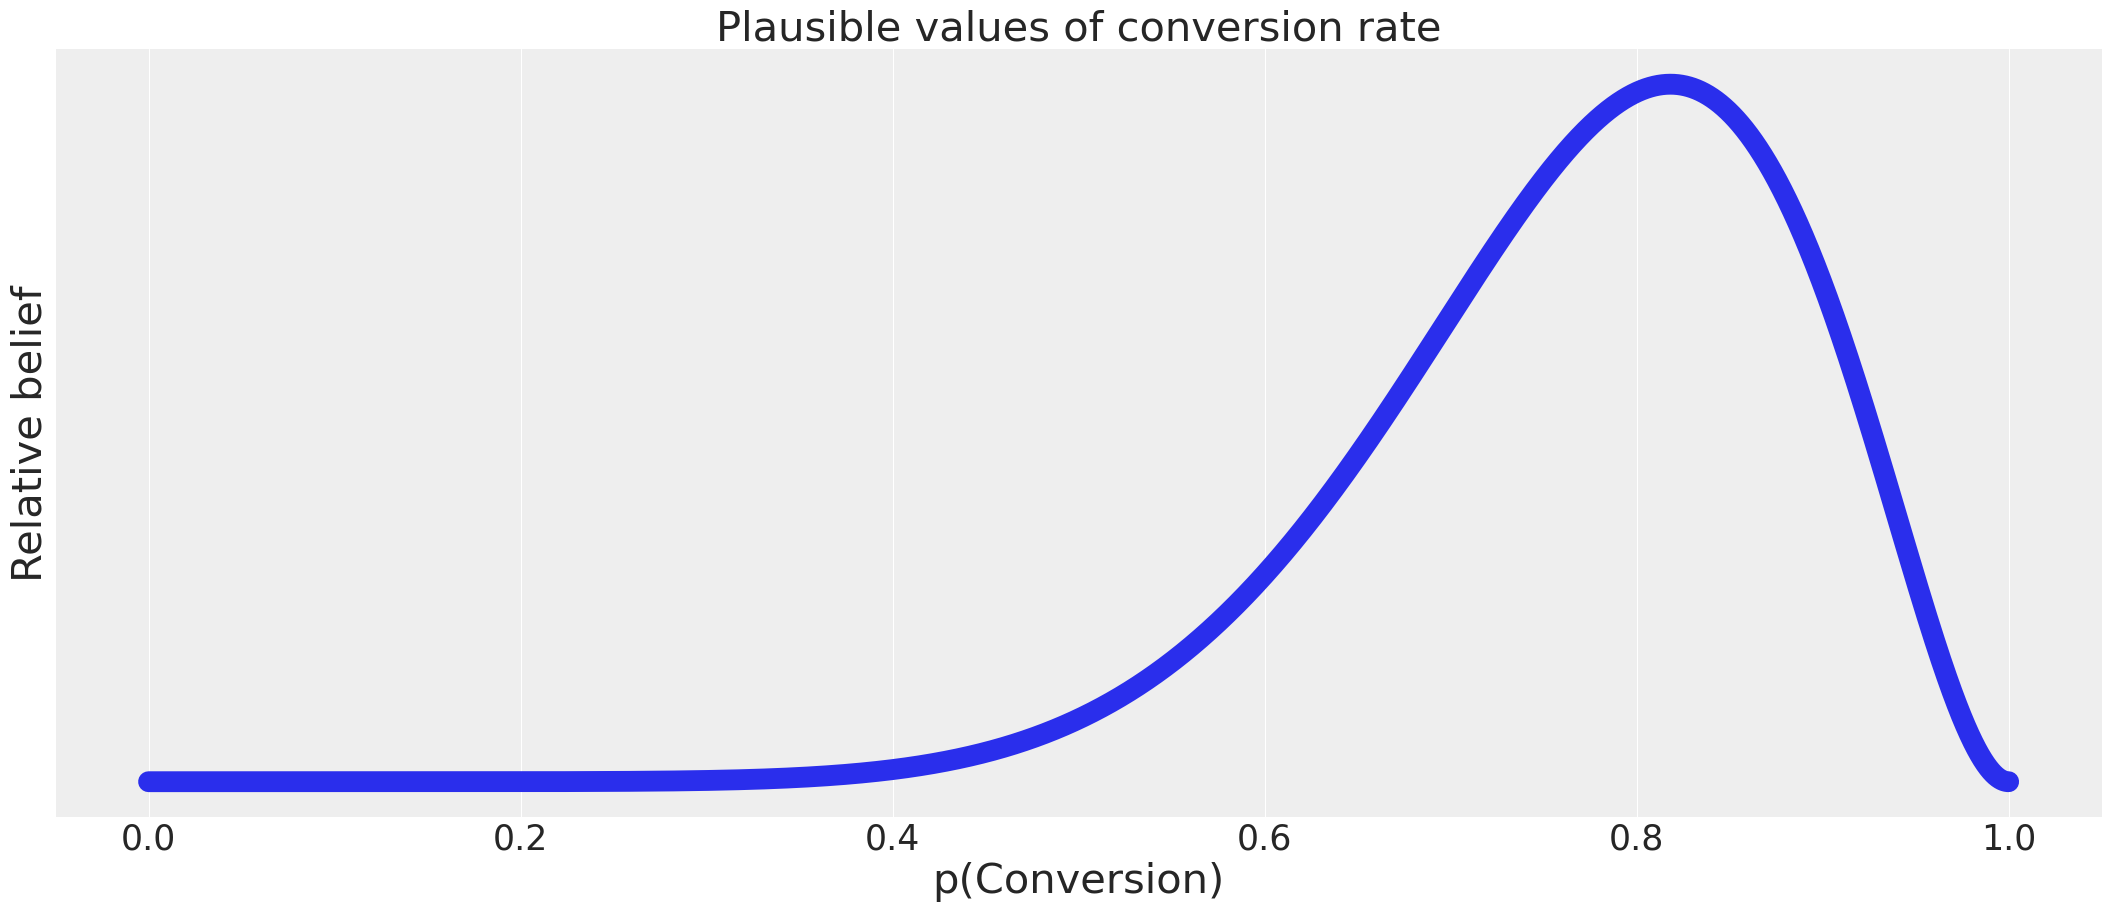

In [17]:
beta_dist = stats.beta(10, 3)
x = np.linspace(0, 1, 10000)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Plausible values of conversion rate", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)

The choice of Beta distributions bounds possible values to the domain of (0,1)  
The choice of parameters is what specifies the shape of the Beta distribution

But how did we get its shape?

## Multiple Parameterizations of Beta

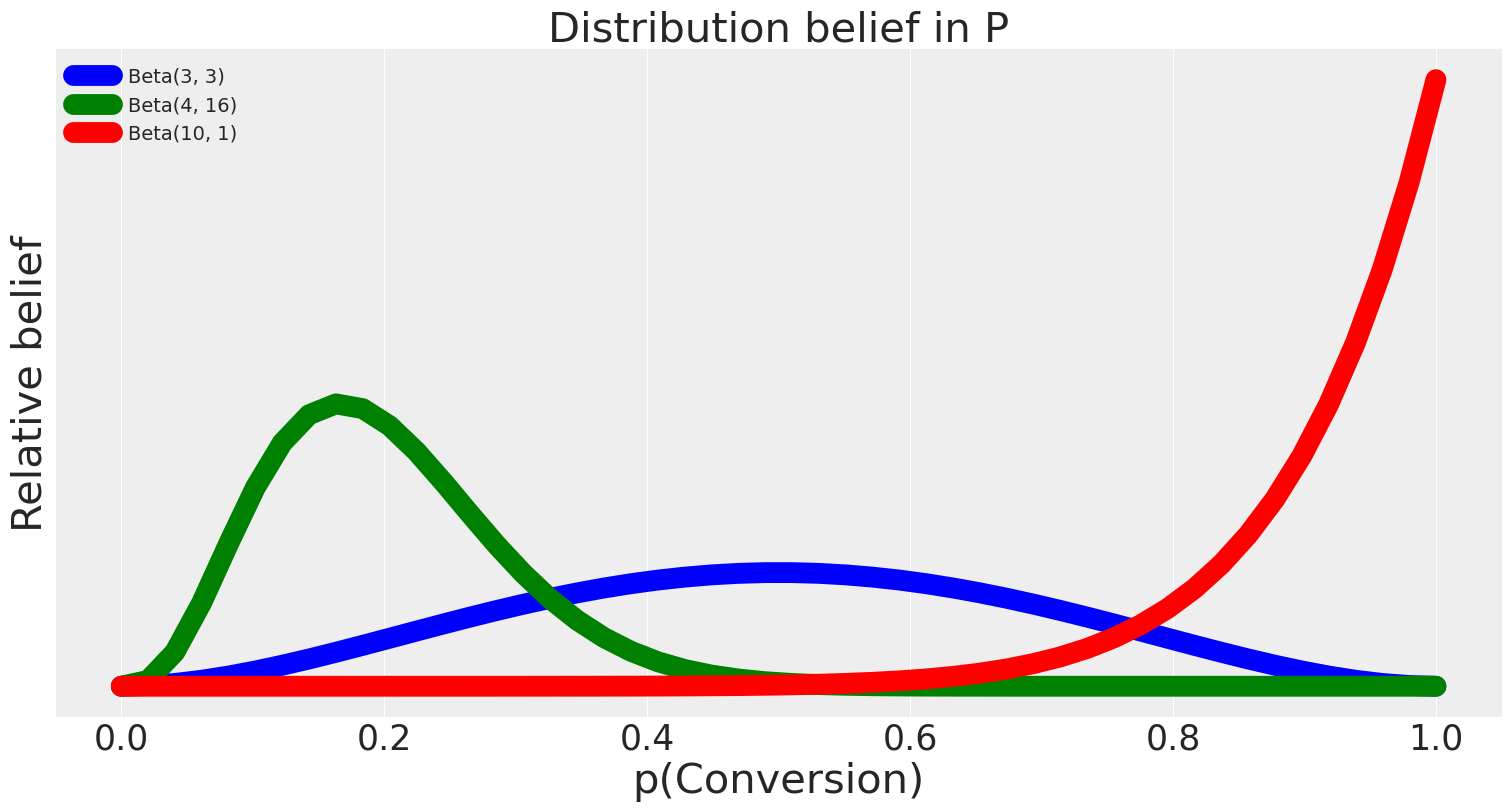

In [17]:
fig, ax = plt.subplots(figsize=(15,8))

for i, (a, b, c) in enumerate(((3,3,'blue'), (4,16,'green'), (10,1,'red'))):

    beta_dist = stats.beta(a, b)
    x = np.linspace(0, 1)
    y = beta_dist.pdf(x)
    ax.plot(x,y, linewidth=15, c=c, label=f"Beta({a}, {b})")

    ax.set_yticks([])
    ax.set_title("Distribution belief in P", fontsize=30)
    ax.set_xlabel("p(Conversion)", fontsize=30)
    ax.set_ylabel("Relative belief", fontsize=30)
    ax.tick_params(axis='x', labelsize=25)

ax.legend();

Here are three distributions with different parameterizations. 

The parameters control their shape, which reflects our relative belief

## Unfortunately notation and naming is not always consistent

Multiple parameters convention 
* Greek Symbols
* Phonetic Greek
* Intuitive Naming

In [18]:
# Greek Symbols
μ = 0
σ = 1
norm_1 = stats.norm(μ, σ)

In [19]:
# Phonetic Names
mu = 0
sigma =1
norm_1 = pm.Normal.dist(mu=mu, sigma=sigma)

In [20]:
# Intuitive Names
norm_1 = stats.norm(loc=0, scale=1)

**Editors note**: Narrate extra long here, then have Fadi fade in a video of the pymc docs


Distributions are used by a wide variety of people across a wide variety of fields. The wide applicability is a great, but what is not is the subtle inconsistencies.

Mathematically identical distributions can be parameterized using different symbols depending on who wrote the code or library, even if the underlying distribution is the same.

For example, more mathematical authors will use Greek symbols
And in other cases they are parameterized by intuitive names, such as "loc" short for location, or "scale"

While we wish the world was standardized it unfortunately is not the case. Refer to the documentation of each library used to double check what you intend to specify is indeed what the library is expecting.

The good news is after some time you'll be able to read all forms of notation equally well.

## Section Recap
* Distributions are
  * Defined by math 
  * Implemented in code
* Two things are needed to fully specify a distribution
    * The specific distribution itself
    * The parameters for that distribution
* Distribution parameterization naming is not consistent across libraries and sources
  * Use references often when starting out to get things right

# Probability Mass and Density Functions

How to precisely determine our relative belief in each value

## Our beta p(conversion) for our A/B test
We've discussed how 

1. We want describe our possible set of beliefs of the conversion rate p(conversion)
2. We can use a Beta distribution for this purpose
3. We can specify the parameter of our Beta function to highlight a specific belief

What we have not shown yet  
* how we precisely measure the specific belief

## Our distribution

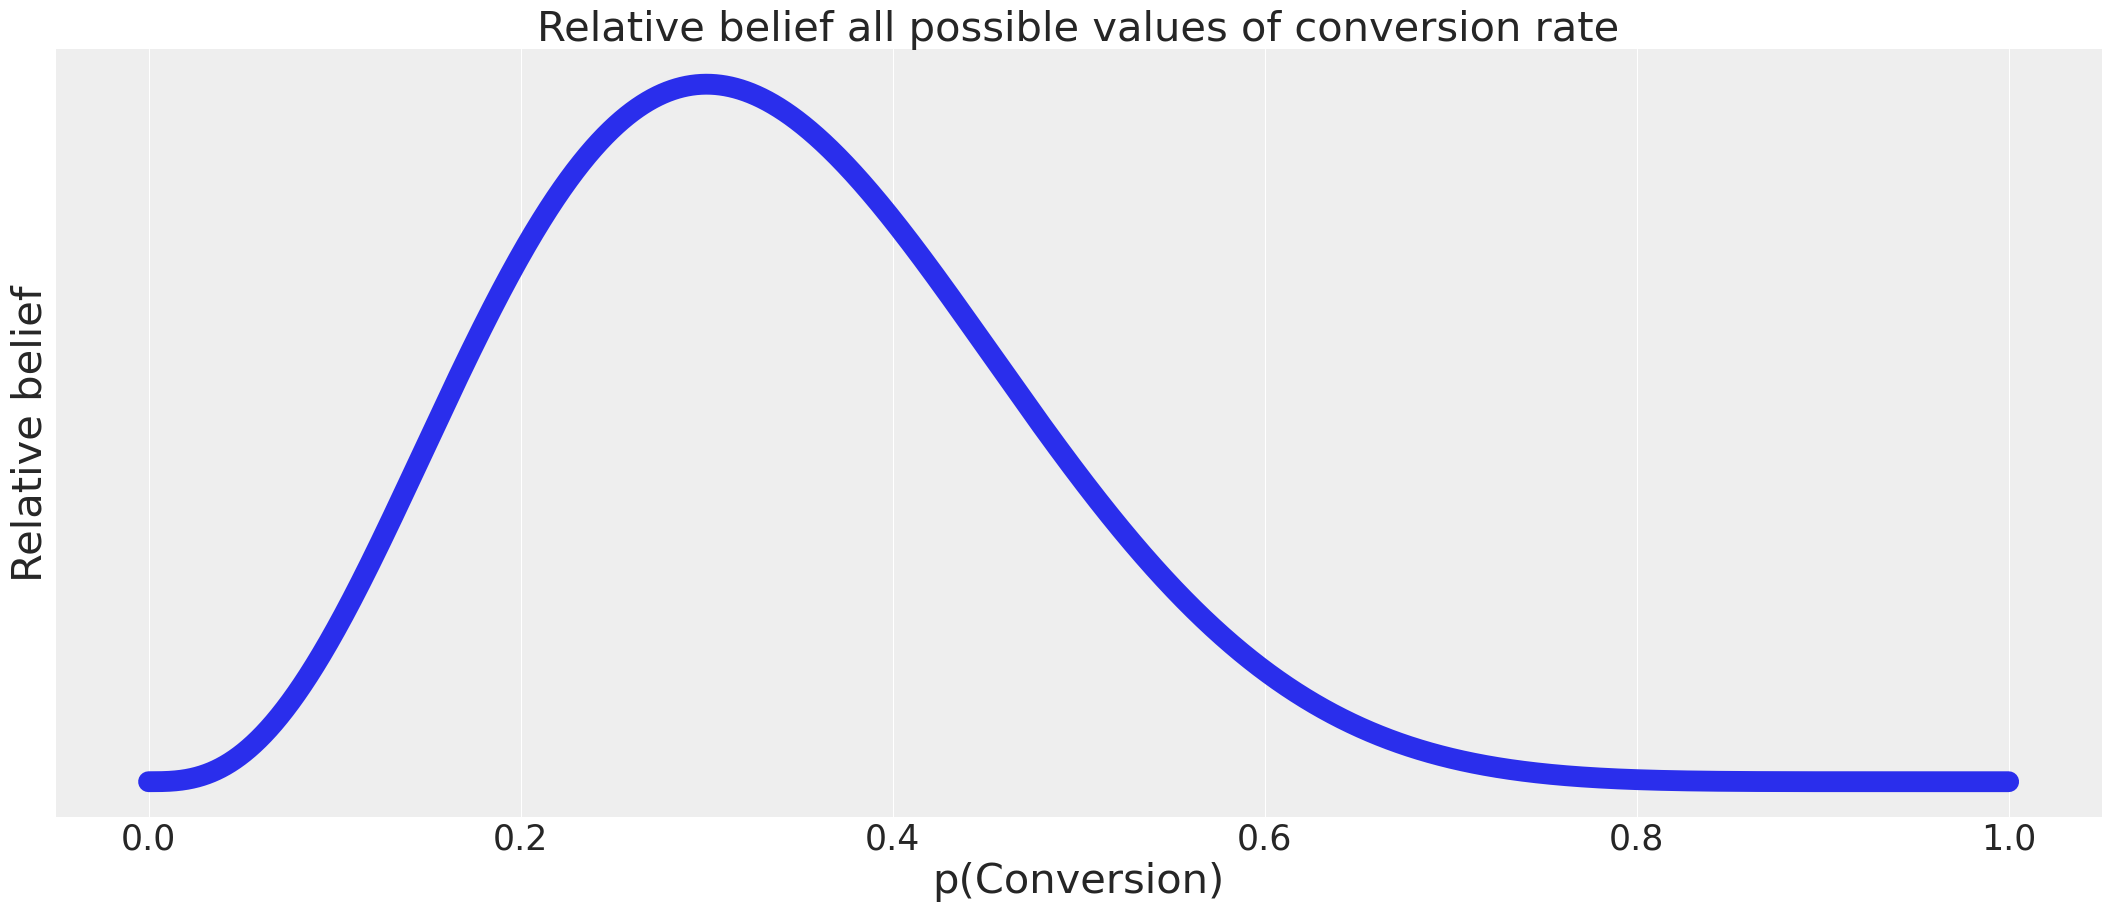

In [68]:
beta_dist = stats.beta(4, 8)
x = np.linspace(0, 1, 10000)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Relative belief all possible values of conversion rate", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)

## Probability of one person converting

In [22]:
# Assume we known the p value precisely
p = 0.3

# Specify a bernoulli distribution
bern = stats.bernoulli(p)

When someone visits our website they either *convert* or *don't convert*  

Let's assume the probability of one person converting is precisely **30%**, or .3  
We can use a *Bernoulli* distribution to model this situation

A Bernoulli distribution only requires one parameter, p, to fully specify

## Probability Mass Function

In [23]:
bern.pmf(0), bern.pmf(1)

(0.7, 0.3)

1 represents *conversion*, and 0 represents *didn't convert*

Now that we've defined a probability distribution computationally we can use it to determine the amount of *mass* associated with the potential outcomes 0 and 1 using the `.pmf` method.

In this case we measure the probability of them converting, represented by 1, is 30%, but the probability of them not converting is 70%. Seems obvious, and I'm glad the computer agrees. But what about more complicated scenarios

## Plotting Probability Mass Function
The vertical height represents the proportion of mass associated with each outcome 0 and 1. 

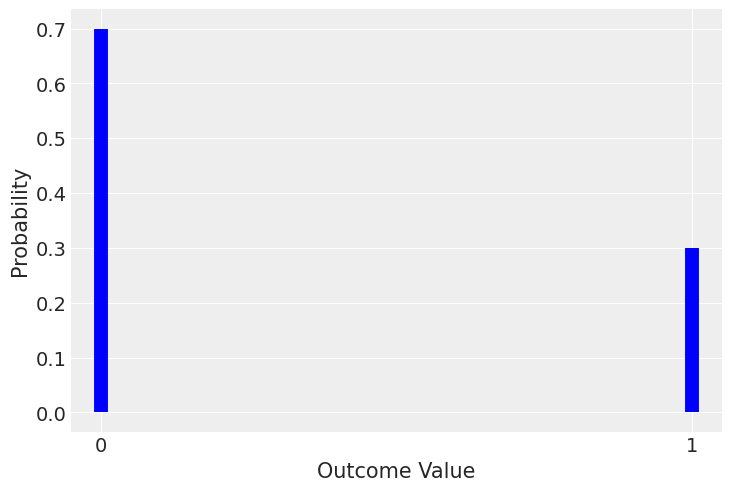

In [72]:
fig, ax = plt.subplots()
potential_outcomes = np.arange(2)
ax.set_xlabel("Outcome Value")
ax.set_ylabel("Probability")
ax.set_xticks([0,1])
ax.vlines(potential_outcomes, 0, bern.pmf(potential_outcomes), colors='b', linestyles='-', lw=10);

Right now you may be thinking Well "duh", that was obvious. We didn't need a computer to tell us that. Let's work through a more complicated case.

## What about multiple users?

<center> <img src="img/ManyUsers.png" width="1200"/></center>

The Bernoulli distribution only tells us the probability if one person converted?

What if we now are interested in the probability of number of conversions in a group of 10 people. 

## The binomial distribution

Two parameters needed to specify the Binomial distribution 
* *p* the probability conversion for a single person 
* *n* the number of people in the group. 

What is probability of X number of people convert if our group size is N?

## Calculating a probability k people convert out of N=10


In [25]:
probability_of_individual_converting = .3
number_of_people_visiting_site = 10

binom = stats.binom(p=probability_of_individual_converting,
                    n=number_of_people_visiting_site)


###  Four conversions

In [26]:
number_of_conversions = 4
binom.pmf(number_of_conversions)

0.2001209489999999

###  Seven conversions

In [27]:
number_of_conversions = 7
binom.pmf(number_of_conversions)

0.009001691999999992

The probability mass function here is telling us that 20% of the *mass* of the distribution is associated with the outcome *4 people convert*

If we instead want to know the probability that 7 people convert we can plug that number in as well, and intuitively the mass is lower. With a 30% probability of conversion we would expect 7 conversion to be *less likely* than 4 conversions.

## Plotting a binomial distribution

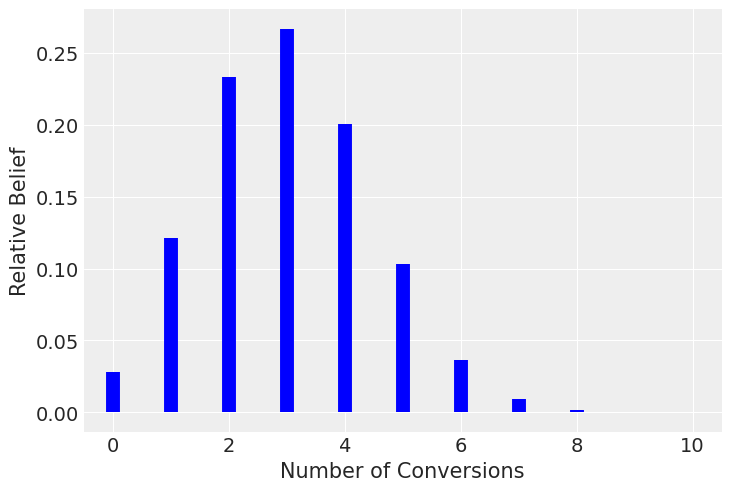

In [28]:
fig, ax = plt.subplots()
potential_outcomes = np.arange(11)
ax.vlines(potential_outcomes, 0, binom.pmf(potential_outcomes), colors='b', linestyles='-', lw=10)
ax.set_ylabel("Relative Belief")
ax.set_xlabel("Number of Conversions");

Because we defined things computationally we can use our handy plotting tools to visualize the probability mass function.

As we would expect 3 people converted is the most likely.

## But what about continuous distributions?

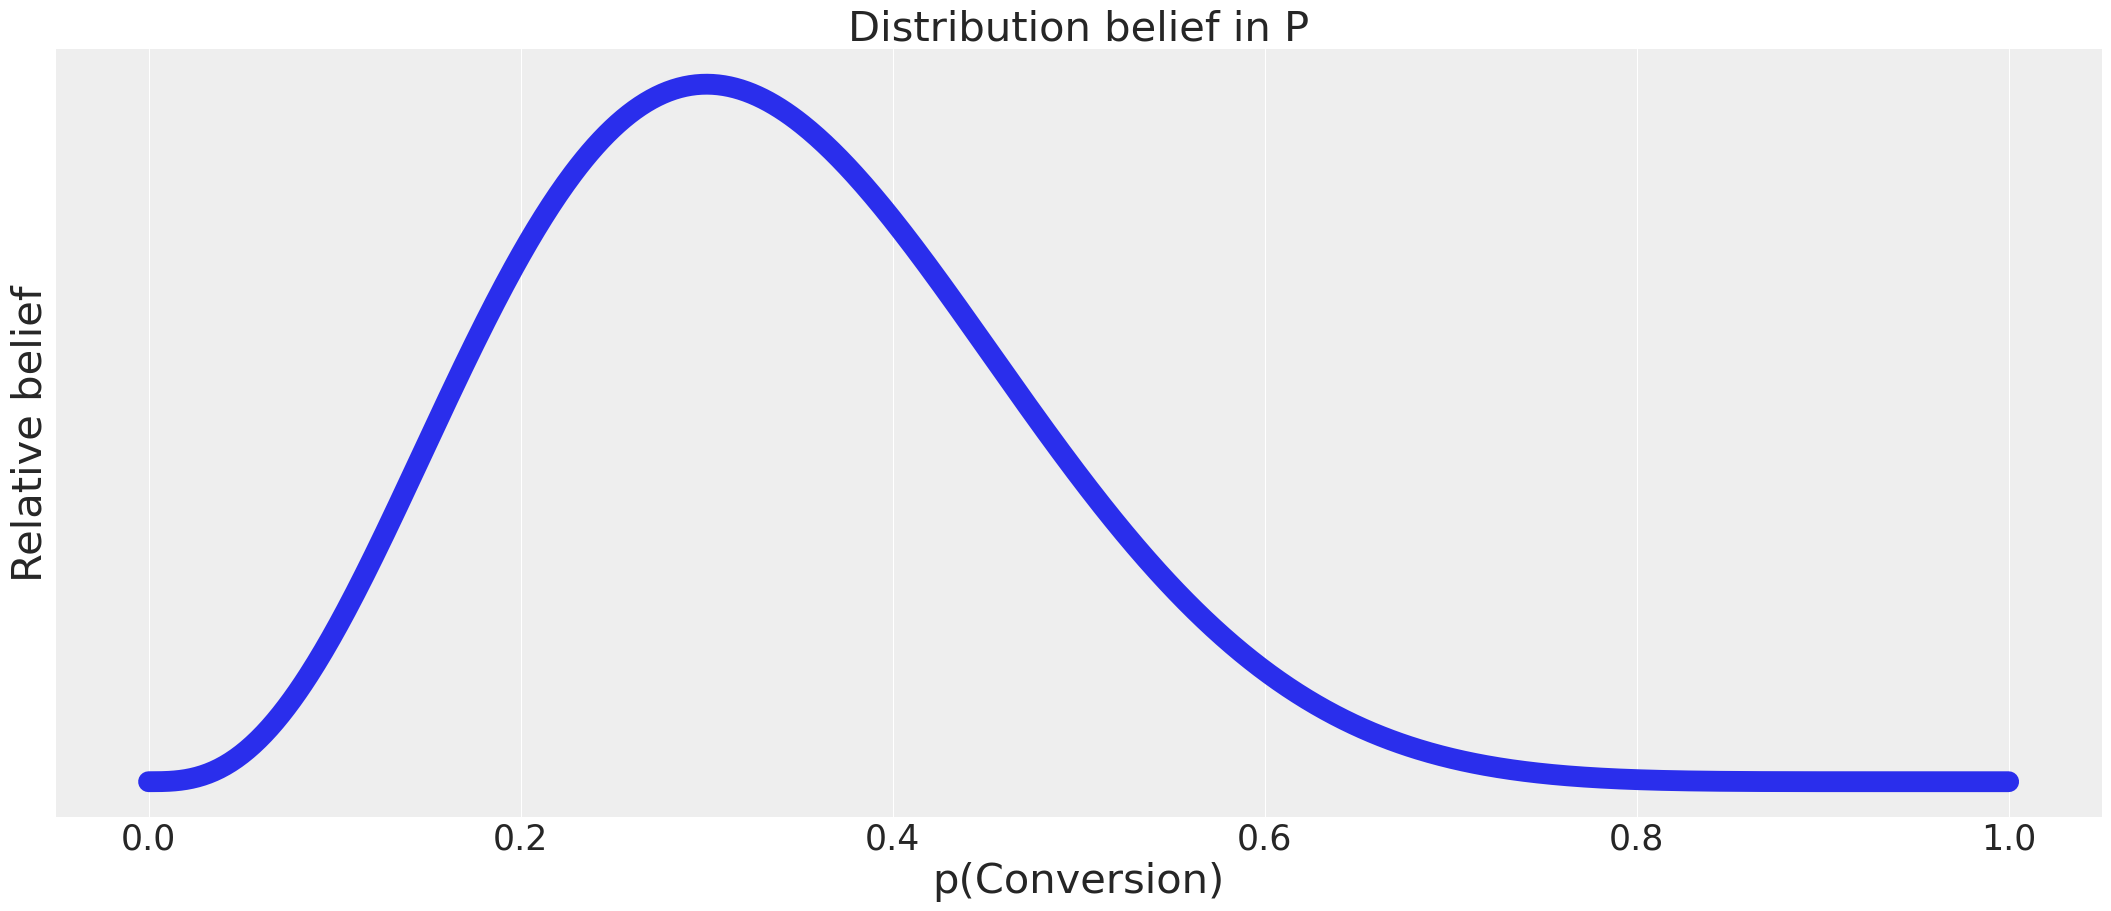

In [73]:
# Hide Code Block
beta_dist = stats.beta(4, 8)
x = np.linspace(0, 1, 1000)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)
ax.set_yticks([]),
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)

But what continuous outcomes, like our Beta distribution for p(conversion), where there isnt just a fixed set of values but a continuous range of values?


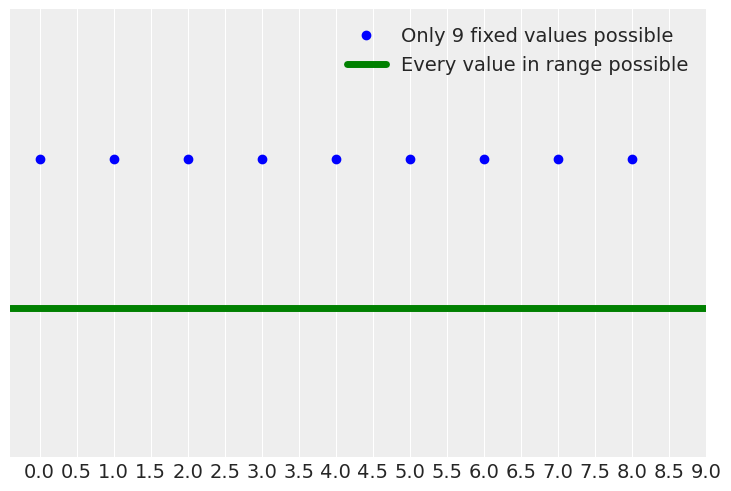

In [30]:
# This is skipped but in videos, leaving it in for reference
fig, ax = plt.subplots()

points = np.arange(9)

for i in points:
    ax.plot(i,2,'o', c='b', label="Only 9 fixed values possible" if i == 0 else "")

ax.axhline(1, c='g', lw=5, label="Every value in range possible")

ax.set_xticks(np.linspace(0,9, 19))
ax.set_ylim(0,3)
ax.set_yticks([])
plt.legend();

## Probability Density Functions

In [19]:
beta_dist = stats.beta(4, 8)
beta_dist.pdf(.3233243)

2.898364724572644

With continuous distributions we can precisely compare different values using a probability *density* function.

But what does this number mean exactly?

## Compare relative values

In [32]:
belief_true_conversion_is_30_percent = beta_dist.pdf(.3)
belief_true_conversion_is_50_percent = beta_dist.pdf(.5)

belief_true_conversion_is_30_percent, \
belief_true_conversion_is_30_percent, \
(belief_true_conversion_is_30_percent > belief_true_conversion_is_50_percent)

(2.9351072519999977, 2.9351072519999977, True)

PDFs take in a value, and output the relative *likelihood* of that value occurring given a distribution.

The numbers here are telling us that probability value of conversion of 30% is more likely than one of 50% given our distribution.

## Just compare the heights
The red lines represent the PDF values of 30% and 50%

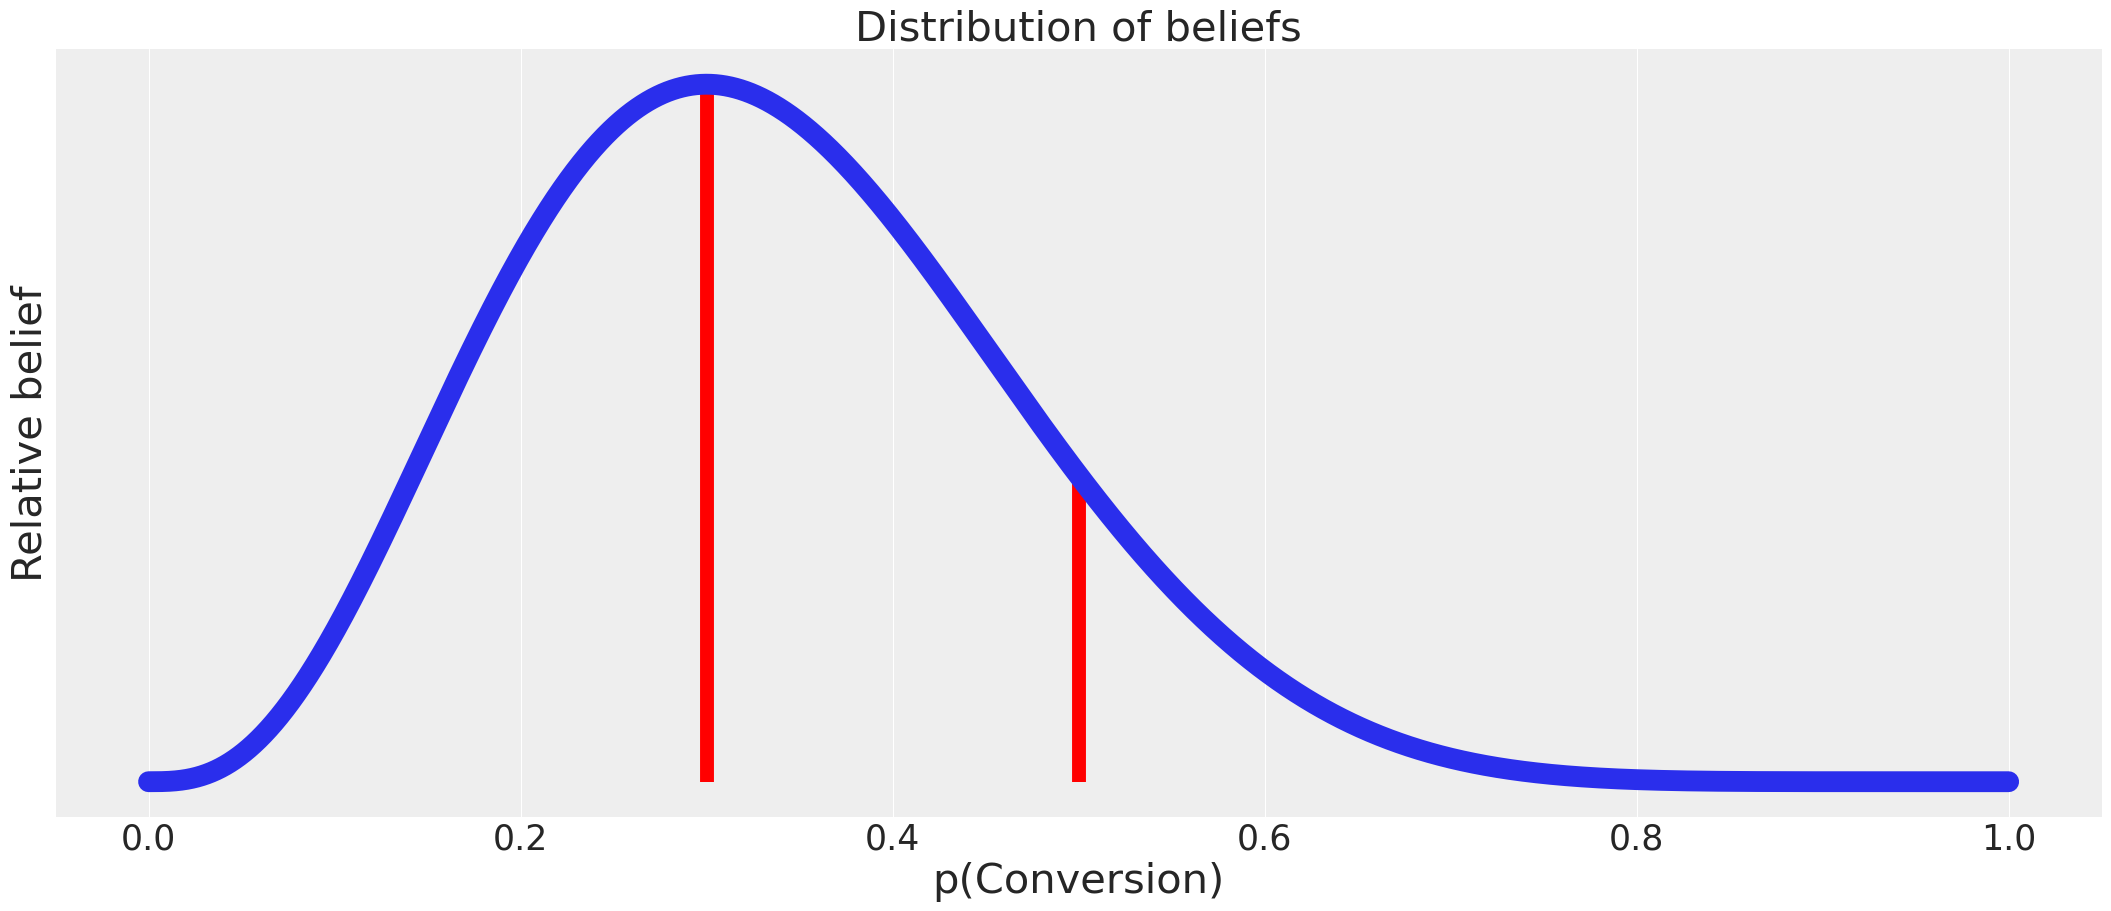

In [20]:
x = np.linspace(0, 1, 10000)
y = beta_dist.pdf(x)

fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)
ax.set_yticks([])
ax.set_title("Distribution of beliefs", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
markerline, stemline, baseline = ax.stem(.3, beta_dist.pdf(.3), "r")
plt.setp(stemline, linewidth = 10)

markerline, stemline, baseline = ax.stem(.5, beta_dist.pdf(.5), "r")
plt.setp(stemline, linewidth = 10);

By checking this plot its much easier to see the relative likelihood of the two p values and see that our belief that 30% is the true conversion rate is greater than 50%

## PDF is not probability
The probability of any single number in a continuous distribution is **0**,

This is because of the foundational way mathematical measure theory works. In a continuous distribution any single number is infinitely small so it can't have mass. We can get the probability for a *range* of numbers but that's not important for this course.

## What is LogPDF
Its just the PDF value but transformed into the log scale **just for computational reasons**

In [34]:
np.log(beta_dist.pdf(.3)), beta_dist.logpdf(.3)

(1.0767439950314812, 1.0767439950314817)

This is done for purely computational stability reasons. Again this is a computational detail that is not important to understand up front. We bring this up as you may hear the term LogPDF and don't want it to surprise you.

So be aware you may see the the terms PDF, and LogPDF. Just translate that in your head as "a thing that gives me relative likelihoods of seeing a certain value"

## All you need to know
* PMF and PDF are just mathematical rulers used under the hood of Bayesian estimate
* You won't be calculating it yourself, the  PPL will do it for you

<center> <img src="img/ruler-pencil-desig_1355-13.jpg" width="600"  /></center>

<a href="https://www.freepik.com/vectors/education">Education vector created by inventsolutions - www.freepik.com</a>

## Section Recap
* All that matters in the intuition
  * PMF and PDF tells us the relative likelihood  of that belief versus any other belief 
* LogPDF the same concept
  * just with a mathematical transform applied
  * just for computational reasons
* You won't need to calculate PDFs yourself, the PPL takes care of it for you

# Two Types of Samples and Two Types of Spaces
1. Observed and computational samples  
2. Observed and parameter spaces

## A/B Test Observations

How many visitors can we get to convert? 

<center> <img src="img/graphic-designers-discussing-laptop.jpg" width="600"/></center>

Proposed image
<center> <img src="img/crowd-people-sale-discounts-stampede-danger-lot-people-excitement-panic_158415-216.png" width="600"/></center>



In our A/B test we showed 100 people website B. Those 100 people are a population sample, meaning they are meant to represent 100 people from the larger group of people that could visit website B sometime in the future.

Importantly these are also samples *we observed*

## Population Samples
These are samples from a "real world" population. Population samples are the samples you typically read about in statistics textbooks.


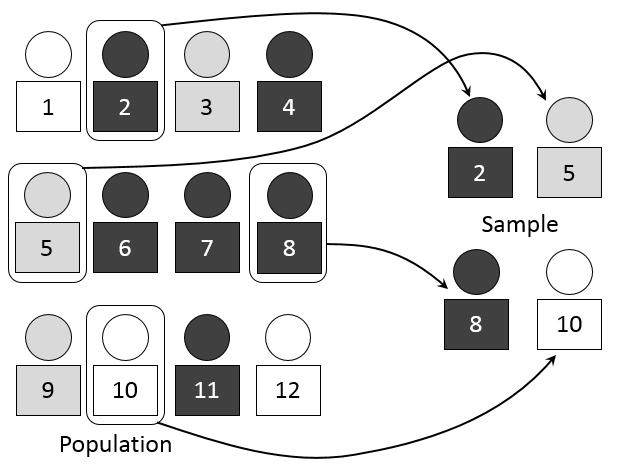
https://en.wikipedia.org/wiki/Sample_(statistics)

### Other Examples
* Calling 10 people to ask who they'll vote for
* Testing a new drug in a treatment trial on 10 people
* Collecting 10 vials of water from 10 lakes to measure toxins

## Computational Samples
Ones that the computer generates "magically"

In [35]:
# Draw a 10000 random samples a
p = 0.3
bern = stats.bernoulli(p)

num_samples = 100000
samples = bern.rvs(num_samples)

# Inspect the first 10
samples[:10], samples.mean()

(array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1]), 0.30243)

The other related concept is taking random values from a computational distribution. These samples are not something that we've observed or counted. They purely are random draws from a computer.

For example we can define a Bernoulli distribution computationally and take 10000 samples
These samples are not of any population we've observed. It's purely us defining a distribution in a computer and values from that distribution that are generated at random.

## Computational samples from a Normal distribution

In [36]:
unit_norm = stats.norm(0,1)
unit_norm.rvs(10)

array([-0.20608892,  0.23643671,  0.48817872, -1.33824131,  0.74228141,
       -0.28825648,  0.92967355, -0.36131552,  0.14049961, -1.3632263 ])

We can do do the same for a Normal distribution

## Taking 10,000 samples and plotting

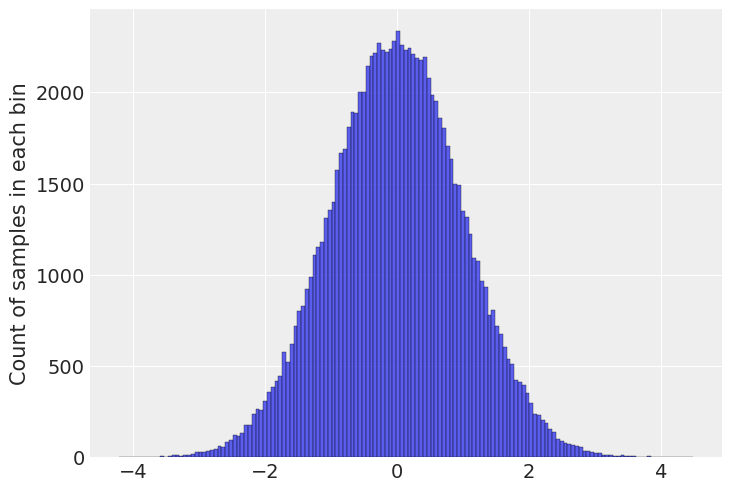

In [37]:
ax = sns.histplot(unit_norm.rvs(100000))
ax.set_ylabel("Count of samples in each bin");

Let's do the same thing again but with Normal distributions. Here's an example of 10000 random draws. Because we're now working with samples we can create bins and just count. Remember how we said statistics is counting, this is what we meant. 


Now that we've listed two types of samples let's talk about two types of spaces

## Two Types of Spaces
Remember distributions can represent things both parameters and observed outcomes

In [38]:
num_customers_per_group = 100

# Parameter Space: Unobserved conversion probability
conversion_rate_samples = stats.beta(1,1).rvs(10000)

# Sample Space: The number of conversions we could see out of 100 users
actual_conversion_samples = stats.binom(p=conversion_rate_samples, n=num_customers_per_group).rvs(10000)


In [39]:
f"Parameter Space: {conversion_rate_samples[:5]}"

'Parameter Space: [0.22658216 0.77389668 0.73928597 0.22826349 0.40141871]'

In [40]:
f"Observed Space: {actual_conversion_samples[:5]}"

'Observed Space: [22 75 67 17 33]'

## Plotting both spaces

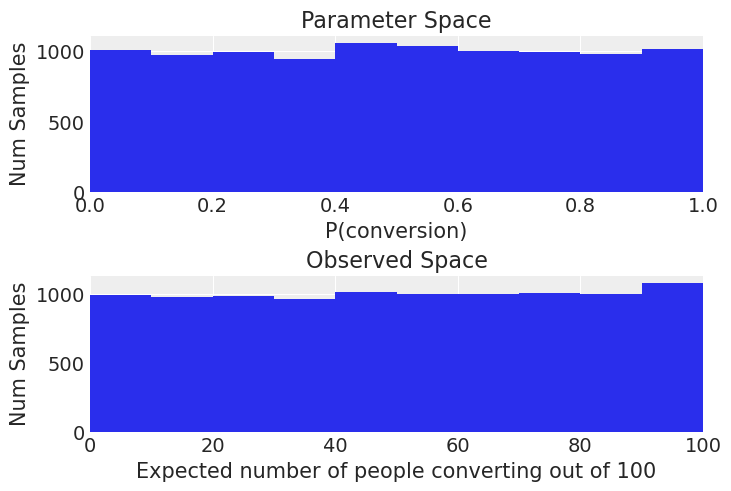

In [41]:
fig, axes=plt.subplots(2,1)


axes[0].hist(conversion_rate_samples)
axes[0].set_title("Parameter Space")
axes[0].set_xlabel("P(conversion)")
axes[0].set_ylabel("Num Samples")


axes[1].hist(actual_conversion_samples)
axes[1].set_title("Observed Space")
axes[1].set_xlabel("Expected number of people converting out of 100")
axes[1].set_ylabel("Num Samples")

axes[0].set_xlim(0,1)
axes[1].set_xlim(0,100);

Here's both plots, and we'll show you the code so you know we're not hiding anything. All were doing is taking our samples and counting them

## What if we believe our conversion rate is 90% and we're very sure
All we need to change is our parameter distribution

In [42]:

# Our parameter distribution has changed to reflect our new belief
conversion_rate_samples = stats.beta(70,30).rvs(10000)

# There is no change here, go back to verify it yourself!
actual_conversion_samples = stats.binom(p=conversion_rate_samples, n=num_customers_per_group).rvs(10000)

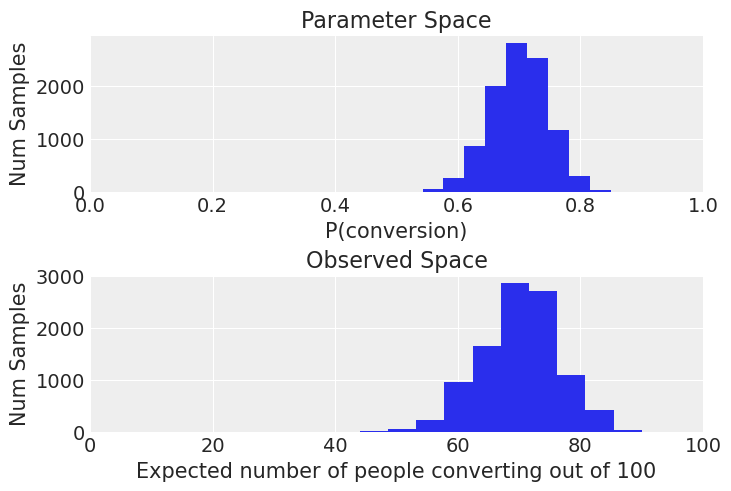

In [43]:
fig, axes = plt.subplots(2,1)

axes[0].hist(conversion_rate_samples)
axes[1].hist(actual_conversion_samples)

axes[0].set_title("Parameter Space")
axes[0].set_xlabel("P(conversion)")
axes[0].set_ylabel("Num Samples")


axes[1].set_title("Observed Space")
axes[1].set_xlabel("Expected number of people converting out of 100")
axes[1].set_ylabel("Num Samples");

axes[0].set_xlim(0,1)
axes[1].set_xlim(0,100);

Same plots, note how by changing the parameter distribution we see a change in our observed space as well, with the histogram now reflecting what we *think* will happen. 

Spoiler alert this second plot is called a predictive distribution, but we'll get to that in the next lesson.

# Review note: I will be moving this to the Bayes Lesson
Ignore it for now as I'll delete it after its moved
## Sampling is foundation of Monte Carlo algorithms (and this course)

The magic behind the Magic Inference Button (TM)

<center> <img src="img/TracePlot.png" width="1000"  /></center>



Markov Chain Monte Carlo is one of the most popular ways of effectively utilizing Bayes Theorem in practice. in fact you've already seen it! It was that `pm.sample` line of code you saw earlier.


MCMC It relies entirely on taking samples in clever ways, and the information from those samples is what enables all inferential magic we're looking for.

Computers made this all possible which is why you're seeing such an explosion of Bayes usage today.


This plot is a preview of one you'll see in a future lesson. On the right is a trace plot showing all those samples in parameter space that are helping us figure out our beliefs given the data. Just a taste of all fun to come.

## Section Recap
* There are two kinds of samples we'll be using in this course.
    * Observed data, which is samples from the "real world"
    * Computational samples, which are samples from computationally defined distributions
* Computational sampling is the foundation for Monte Carlo algorithms
    * Notably Markov Chain Monte Carlo, the algorithm that makes Bayesian methods so accessible 
* Using population and computational samples together is what enables *inference* 


# Lesson Recap
*note* Need to expand this once full lesson is complete

1. Distributions enable belief specification 
2. Computational distributions allow for easy sampling
3. PMF and PDF provide strict measures to those beliefs
4. Computational sampling enables clever algorithms MCMC
